In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0569-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0523-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1285-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1262-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1017-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0971-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0937-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0561-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0425-0001.jpeg
/kaggle

In [2]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

In [3]:
import keras
from keras.models import Model,Sequential
from keras.layers import Input,Dense,BatchNormalization,Flatten,Dropout
from keras.layers import Conv2D,SeparableConv2D,MaxPool2D,LeakyReLU,Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
import tensorflow as tf

seed=232
np.random.seed(seed)
tf.random.set_seed(seed)

**Setting the seed to run the same set of data at every run**

In [4]:
tf.__version__

'2.3.1'

UnidentifiedImageError: cannot identify image file '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store'

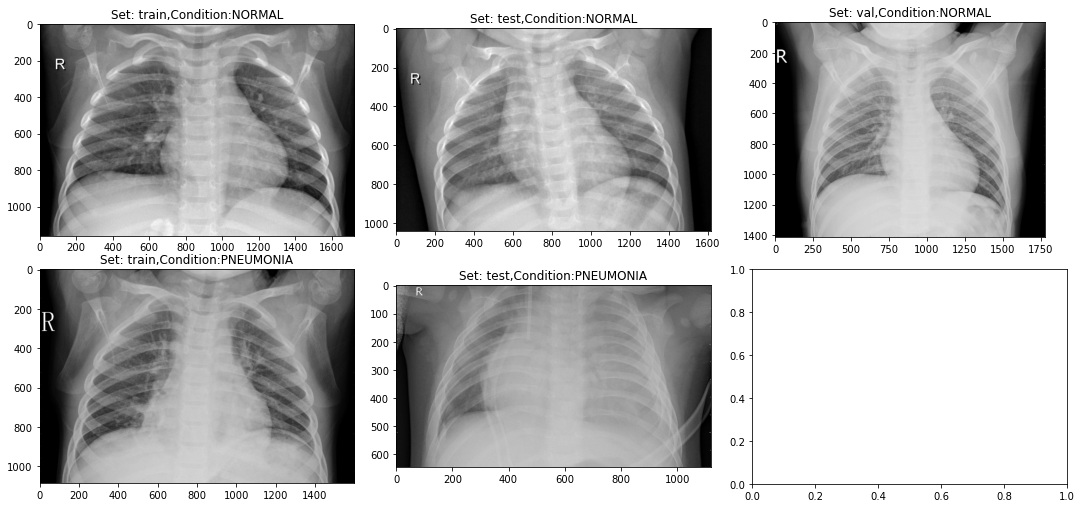

In [5]:
input_path="../input/chest-xray-pneumonia/chest_xray/chest_xray/"

fig,ax=plt.subplots(2,3,figsize=(15,7))
ax=ax.ravel()       #to flatten into 1D array
plt.tight_layout() #to pad between the images from their subplot images

for i,set_ in enumerate(['train','test','val']):
    set_path=input_path+set_
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL/')[0]),cmap='gray')
    ax[i].set_title('Set: {},Condition:NORMAL'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]),cmap='gray')
    ax[i+3].set_title('Set: {},Condition:PNEUMONIA'.format(set_))

In [6]:
for set_ in ['train','val','test']:
    normal=len(os.listdir(input_path+set_+'/NORMAL'))
    pneum=len(os.listdir(input_path+set_+'/PNEUMONIA'))
print('Normal images: ',normal)
print('Affected images: ',pneum)

Normal images:  234
Affected images:  390


In [7]:
input_path

'../input/chest-xray-pneumonia/chest_xray/chest_xray/'

# Train & Test data

In [8]:
def process_data(img_dims,batch_size):
    
    #Data generation objects
    train_datagen=ImageDataGenerator(rescale=1./255,zoom_range=0.3,vertical_flip=True)
    test_datagen=ImageDataGenerator(rescale=1./255)
    
    #To fed to network of batch_size and correct image dimension
    train_gen=train_datagen.flow_from_directory(
        directory=input_path+'train',
        target_size=(img_dims,img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    test_gen=test_datagen.flow_from_directory(
        directory=input_path+'test',
        target_size=(img_dims,img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    #Making one batch of prediction to test set
    test_data=[]
    test_label=[]
    
    for cond in ['/NORMAL/','/PNEUMONIA/']:
        for img in (os.listdir(input_path+'test'+cond)):
            img=plt.imread(input_path+'test'+cond+img)
            img=cv2.resize(img,(img_dims,img_dims))
            img=np.dstack([img,img,img])
            img=img.astype('float32')/255
            if cond=='/NORMAL/':
                label=0
            elif cond=='/PNEUMONIA/':
                label=1
            test_data.append(img)
            test_label.append(label)
                
    test_data=np.array(test_data)
    test_label=np.array(test_label)
    
    return train_gen,test_gen,test_data,test_label

In [9]:
# Hyperparameters
epoch=10
batch_size=64
img_dims=150

#Get the data
train_gen,test_gen,test_data,test_label=process_data(img_dims,batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building CNN model

In [10]:
#Input
inputs=Input(shape=(img_dims,img_dims,3))

x=Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same')(inputs)
x=Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same')(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#Fully connected layer
x=Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

#Output layer
output=Dense(1,activation='sigmoid')(x)

#Model creation & compiling
model=Model(inputs=inputs,outputs=output)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#Callback
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# Fitting the model

In [11]:
hist=model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
              epochs=epoch,validation_data=test_gen,validation_steps=test_gen.samples//batch_size,
              callbacks=[checkpoint,lr_reduce])

Epoch 1/10
81/81 [==============================] - 112s 1s/step - loss: 0.3736 - accuracy: 0.8210 - val_loss: 0.9223 - val_accuracy: 0.6267
Epoch 2/10
81/81 [==============================] - 99s 1s/step - loss: 0.2711 - accuracy: 0.8889 - val_loss: 0.9843 - val_accuracy: 0.6198
Epoch 3/10
81/81 [==============================] - 100s 1s/step - loss: 0.2532 - accuracy: 0.8946 - val_loss: 1.5032 - val_accuracy: 0.6215
Epoch 4/10
81/81 [==============================] - 100s 1s/step - loss: 0.2182 - accuracy: 0.9138 - val_loss: 0.7421 - val_accuracy: 0.6181
Epoch 5/10
81/81 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9317
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
81/81 [==============================] - 98s 1s/step - loss: 0.1887 - accuracy: 0.9317 - val_loss: 0.7938 - val_accuracy: 0.6267
Epoch 6/10
81/81 [==============================] - 99s 1s/step - loss: 0.1640 - accuracy: 0.9400 - val_loss: 1.3730 - val_accuracy: 0

# Validation performance

In [12]:
print(hist.set_params)

<bound method Callback.set_params of <tensorflow.python.keras.callbacks.History object at 0x7fe7f8f51a50>>


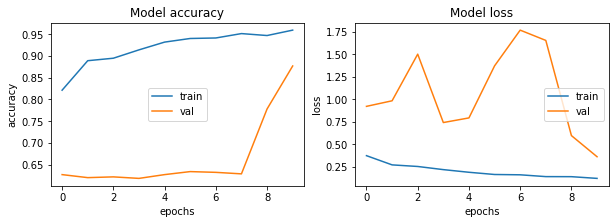

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_label, np.round(preds))*100
cm = confusion_matrix(test_label, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[160  74]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 87.17948717948718%
Precision: 83.84279475982532%
Recall: 98.46153846153847%
F1-score: 90.56603773584905

TRAIN METRIC ----------------------
Train acc: 95.92
